In [1]:
# 숙제 2
import requests
import tarfile
import os
# 데이터 다운로드 URL
urls = [
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
]
# 파일 다운로드 함수
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    local_filename = os.path.join(dest_folder, url.split('/')[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename
# 각 URL에 대해 파일 다운로드
for url in urls:
    download_file(url, 'data')
# 파일 압축 해제
def extract_tar_gz(file_path, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=dest_folder)
# 각 파일에 대해 압축 해제
for url in urls:
    file_path = os.path.join('data', url.split('/')[-1])
    extract_tar_gz(file_path, 'data')

In [4]:
import os

# 디렉토리 구조 확인
for root, dirs, files in os.walk('data'): # os.walk로 data 폴더 내의 파일들을 탐색한다.(root : 탐색 경로, dirs : 현재 디렉토리 목록, files : 파일 목록)
    level = root.replace('data', '').count(os.sep)
    indent = ' ' * 4 * (level) # 몇 칸 띄워줄지(깔끔하게 표시하기 위해)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files: # 폴더 내에 파일이 존재하면, 
        print(f'{subindent}{f}') # 그 파일을 출력

data/
    annotations.tar.gz
    images.tar.gz
    images/
        Egyptian_Mau_167.jpg
        pug_52.jpg
        basset_hound_112.jpg
        Siamese_193.jpg
        shiba_inu_122.jpg
        Siamese_53.jpg
        Birman_167.jpg
        leonberger_6.jpg
        Siamese_47.jpg
        shiba_inu_136.jpg
        saint_bernard_139.jpg
        Birman_173.jpg
        Abyssinian_225.jpg
        basset_hound_106.jpg
        miniature_pinscher_200.jpg
        Siamese_187.jpg
        wheaten_terrier_49.jpg
        Egyptian_Mau_173.jpg
        pug_46.jpg
        shiba_inu_43.jpg
        wheaten_terrier_61.jpg
        saint_bernard_111.jpg
        scottish_terrier_132.jpg
        scottish_terrier_126.jpg
        saint_bernard_105.jpg
        saint_bernard_2.jpg
        pomeranian_189.jpg
        Abyssinian_219.jpg
        shiba_inu_57.jpg
        wheaten_terrier_75.jpg
        german_shorthaired_131.jpg
        english_setter_170.jpg
        pug_91.jpg
        newfoundland_137.jpg
        pomer

In [8]:
input_dir = 'data/images/'
target_dir = 'data/annotations/trimaps'

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')])

target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) 
                       if fname.endswith('.png') and not fname.startswith('.')])

print(f'input image : {len(input_img_paths)}')
print(f'target image : {len(target_paths)}')

input image : 7390
target image : 7390


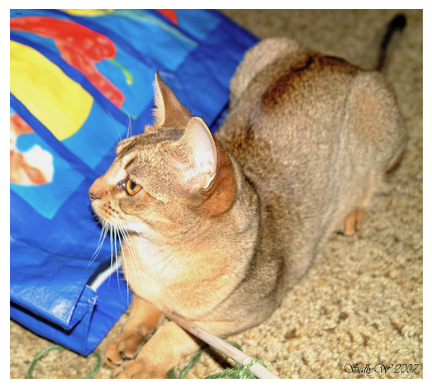

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

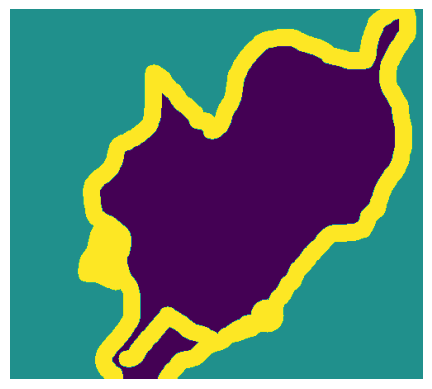

In [15]:
# 정규화 작업 처리
def display_target(target_array):
    normalized_array = (target_array.astype('uint8') - 1) * 127 # 0~255 사이의 값을 가질 수 있게 설정
    plt.axis('off')
    plt.imshow(normalized_array[:, :, 0]) # grayscale 유일한 채널

img = img_to_array(load_img(target_paths[9], color_mode='grayscale'))
display_target(img)

In [23]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths) # 1337 시드값(이미지 리스트를 섞어줌)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path): # img를 Numpy 배열로 변환
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path): # img를 grayscale로 바꾼 다음 Numpy 배열로 변환
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype('uint8') - 1
    return img


In [24]:
input_imgs = np.zeros((num_imgs, ) + img_size + (3, ), dtype='float32') # 입력 이미지를 저장할 Numpy 배열(num_imgs, 200, 200, 3)
targets = np.zeros((num_imgs,) + img_size + (1,), dtype='uint8') # 타겟 이미지를 저장할 Numpy 배열(num_imgs, 200, 200, 1)

for i in range(num_imgs): # 반복문 i가 num_imgs 내에 존재하는 동안
    input_imgs[i] = path_to_input_image(input_img_paths[i]) # input_imgs의 i번째 값에 path_to_input_image 함수 도입
    targets[i] = path_to_target(target_paths[i]) # target_paths의 i번째 값에 path_to_target 함수 도입

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples] # 뒤 스필릿
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:] # 앞 스필릿
val_targets = targets[-num_val_samples:] 
# => 학습 데이터와 테스트 데이터를 나누어 주었다.

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) # 입력층 설정
    x = layers.Rescaling(1./255)(inputs) # 정규화 

    # 이미지의 크기가 줄어들고 있다.
    # 히든층, Conv2D = 합성곱
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x) 
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    # 크기 복원 작업을 하면서 진행하고 있다.(이미지의 크기는 늘어나고 있다.)
    # Conv2DTranspose : 합성곱(Conv2D)의 반대인 역합성곱(업샘플링) 연산을 실행
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

    model = keras.Model(inputs, outputs)
    return model

In [27]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [28]:
# 최적화 함수
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)
]

In [ ]:
history = model.fit(train_input_imgs, train_targets, epochs=10, callbacks = callbacks, batch_size=256, 
                    validation_data = (val_input_imgs, val_targets))

In [ ]:
epochs = range(1, len(history.history['loss'])+1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.titile('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('oxford_segmentation.h5')

i = 4
test_image = val_input_imgs[i]
plt.axis('off')
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis('off')
    plt.imshow(mask)

display_maks(mask)